[0.06249912 0.07873712 0.09606707 0.11375475 0.13118596 0.14973305
 0.16804196 0.18650907 0.20553755 0.22405553 0.21783344 0.26020796
 0.27837875 0.29554532 0.31267661 0.32944506 0.34639193 0.36241758
 0.37718528 0.3924614  0.40693521 0.42065907 0.43434314 0.44741349
 0.45998188 0.47152051 0.48274666 0.49397666 0.504188   0.51403722
 0.52346498 0.53239759 0.5409635  0.54917431 0.55672933 0.5638527
 0.57068338 0.5769989  0.58257815 0.58851652 0.59376663 0.59876031
 0.60353227 0.60783277 0.61132889 0.61519993 0.6185375  0.62127002
 0.6243153  0.62688662 0.62937104 0.63149338 0.63333941 0.63501157
 0.63607579 0.63741036 0.63842979 0.63894631 0.63948655 0.63980493
 0.639726   0.63980493 0.63954308 0.63894731 0.63842979 0.63741036
 0.63607579 0.63501157 0.63339636 0.63149338 0.62937104 0.62688662
 0.6243153  0.62127002 0.6185375  0.61519993 0.61132889 0.60783277
 0.60353227 0.59876031 0.59376663 0.58851899 0.58258709 0.5769989
 0.57068338 0.5638527  0.55672933 0.54925386 0.5409635  0.532397

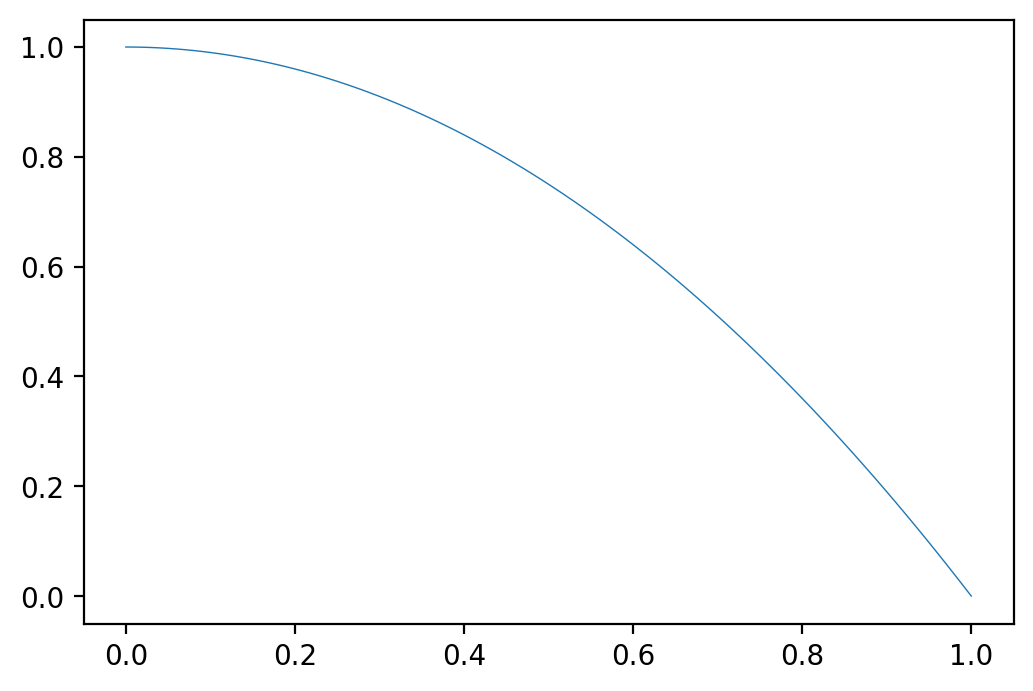

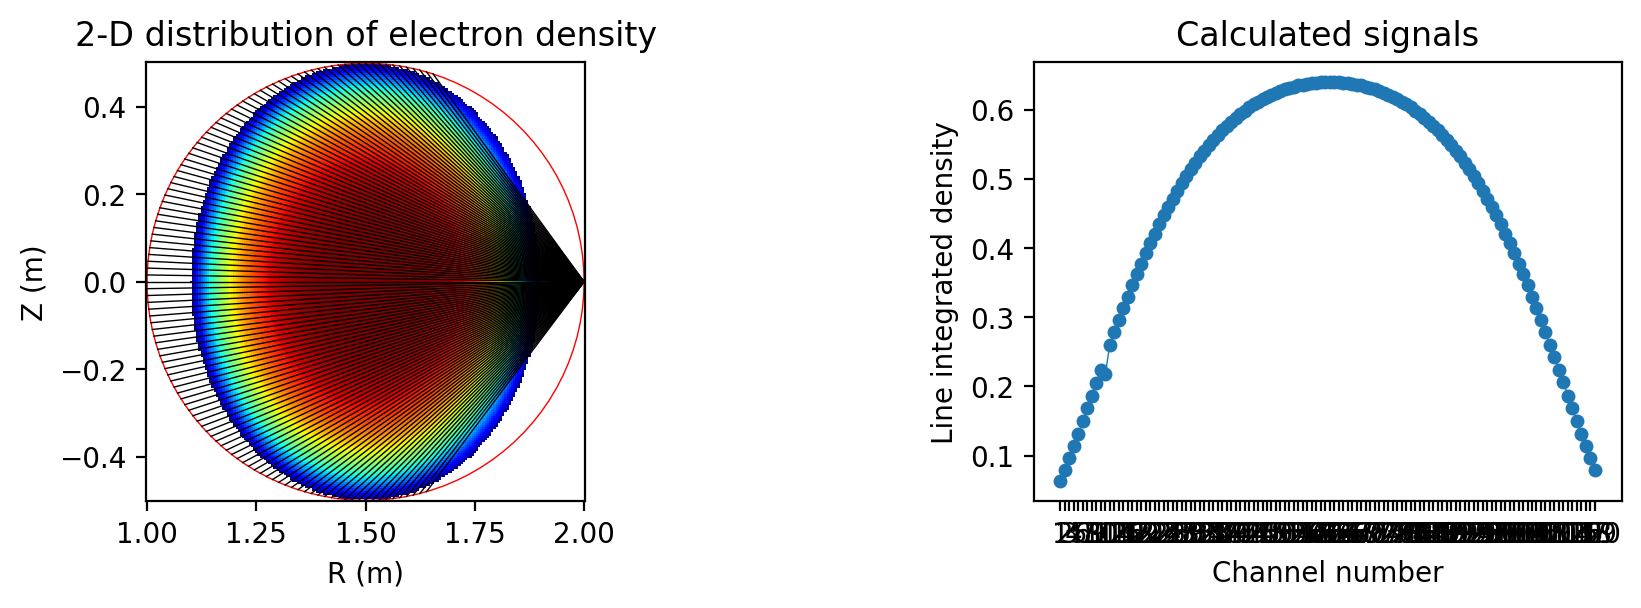

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.spatial import distance


mpl.rcParams["image.cmap"] = 'jet'
mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams["figure.dpi"] = 200


def line_function_x_2d(y, x1, x2, y1, y2):
    """
    The line function is determined by 2 points (x1, y1) and (x2, y2).
    Given a point on the line with an ordinate of y, return the corresponding abscissa x.

    :param y:
    :param x1:
    :param x2:
    :param y1:
    :param y2:
    :return: x or None (if the line is parallel to the x axis)
    """
    return None if y1 == y2 else ((x2 - x1) / (y2 - y1)) * (y - y1) + x1


def line_function_y_2d(x, x1, x2, y1, y2):
    """
    The line function is determined by 2 points (x1, y1) and (x2, y2).
    Given a point on the line with a abscissa of x, return the corresponding ordinate y.

    :param x:
    :param x1:
    :param x2:
    :param y1:
    :param y2:
    :return: y or None (if the line is parallel to the y axis)
    """
    return None if x1 == x2 else ((y2 - y1) / (x2 - x1)) * (x - x1) + y1


def get_nearest_normalized_radii(rho_pixel, rho_discrete):
    '''
    Get the nearest discrete normalized radii

    :param rho_pixel: Normalized radii of all pixels
    :param rho_discrete: Discrete normalized radii
    :return: The indices of the discrete values to which the normalized radius of each point belongs.
    '''
    rho_discrete = np.expand_dims(rho_discrete, -1)
    rho_pixel = np.expand_dims(rho_pixel, -1)
    distances = distance.cdist(rho_discrete, rho_pixel)  # Distance between each pair of the two collections of inputs
    digitized = np.argmin(distances, axis=0)
    return digitized


def compute_cross_points(r_pixel, z_pixel, start_angles, end_angles):
    """
    Get the coordinates of points where each LOS intersects with grid lines

    :param r_pixel: r coordinates of (the centers) of pixels
    :param z_pixel: z coordinates of (the centers) of pixels
    :param start_angles: angles that parameterize the start points of lines of sight
    :param end_angles: angles that parameterize the end points of lines of sight
    :return: The coordinates of points where each LOS intersects with grid lines
    """
    dr = r_pixel[1] - r_pixel[0]
    dz = z_pixel[1] - z_pixel[0]
    grid_r = np.hstack([r_pixel[0] - dr / 2, r_pixel + dr / 2])
    grid_z = np.hstack([z_pixel[0] - dz / 2, z_pixel + dz / 2])
    los_r_start = 1.5 + 0.5 * np.cos(start_angles)
    los_r_end = 1.5 + 0.5 * np.cos(end_angles)
    los_z_start = 0.5 * np.sin(start_angles)
    los_z_end = 0.5 * np.sin(end_angles)
    num_los = los_r_start.shape[0]
    cross_points = np.empty(num_los, dtype=object)
    for i in range(num_los):
        get_cross_x = lambda y: line_function_x_2d(y, los_r_start[i], los_r_end[i],
                                                   los_z_start[i], los_z_end[i])
        get_cross_y = lambda x: line_function_y_2d(x, los_r_start[i], los_r_end[i],
                                                   los_z_start[i], los_z_end[i])
        cross_x = list(map(get_cross_x, grid_z))
        cross_y = list(map(get_cross_y, grid_r))
        points = np.vstack((np.hstack((cross_x, grid_r)),
                            np.hstack((grid_z, cross_y))))
        # Remove invalid points
        indices_invalid = []
        for n in range(points.shape[1]):
            if points[0, n] is None or points[1, n] is None \
                    or points[0, n] < grid_r[0] or points[0, n] > grid_r[-1] \
                    or points[1, n] < grid_z[0] or points[1, n] > grid_z[-1]:
                indices_invalid.append(n)
        points = np.delete(points, indices_invalid, axis=1)
        # Sort by x (if x is the same then sort by y)
        sorted_idx = np.lexsort((points[1, :], points[0, :]))
        cross_points[i] = points[:, sorted_idx]
    return cross_points


def compute_all_chord_lengths(r_pixel, z_pixel, cross_points):
    """
    Compute the length of each chord inside each pixel

    :param r_pixel: r coordinates of (the centers) of pixels
    :param z_pixel: z coordinates of (the centers) of pixels
    :param cross_points: The coordinates of points where each LOS intersects with grid lines
    :return: None
    """
    num_r_pixel = r_pixel.shape[0]
    num_pixels = r_pixel.shape[0] * z_pixel.shape[0]
    num_los = cross_points.shape[0]
    chord_length = np.zeros([num_los, num_pixels])
    for i in range(num_los):
        num_cross = cross_points[i].shape[1]
        # Find which cell that each point of intersection belongs to and compute the chord length
        for j in range(num_cross - 1):
            chord_start = cross_points[i][:, j]
            chord_end = cross_points[i][:, j + 1]
            chord_center = (chord_start + chord_end) / 2
            idx_r = np.argmin(np.abs(r_pixel - chord_center[0]))
            idx_z = np.argmin(np.abs(z_pixel - chord_center[1]))
            dist = scipy.linalg.norm(chord_end - chord_start)
            chord_length[i, idx_z * num_r_pixel + idx_r] = dist
    return chord_length


def compute_response_matrix(chord_lengths, rho_pixel, rho_discrete):
    '''
    Sum the contribution of pixels with the same normalized radius

    :param chord_lengths: The length of each chord inside each pixel
    :param rho_pixel: Normalized radii of all pixels
    :param rho_discrete: Discrete normalized radii
    :return: The length of each chord inside pixel groups with the same normalized radii (num_los, len_rho_discrete)
    '''
    digitized = get_nearest_normalized_radii(rho_pixel, rho_discrete)
    num_los = chord_lengths.shape[0]
    len_rho_discrete = rho_discrete.shape[0]
    response = np.zeros([num_los, len_rho_discrete])
    for i in range(num_los):
        for j in range(len_rho_discrete):
            response[i, j] = chord_lengths[i, digitized == j].sum()
    return response


def map_profile_to_2d(rho_1d, dens_1d, rho_2d):
    '''
    Map 1-D electron density profile to 2-D
    '''
    rho_2d_flat = rho_2d.flatten()
    dens_2d_flat = np.zeros_like(rho_2d_flat)
    indices_inside = np.argwhere(rho_2d_flat <= 1.0).flatten()
    dens_2d_flat[indices_inside] = interp1d(rho_1d, dens_1d, kind='cubic')(rho_2d_flat[indices_inside])
    dens_2d_flat[rho_2d_flat > 1.0] = np.nan
    return dens_2d_flat.reshape(rho_2d.shape)


def plot_example_configuration(start_angles, end_angles, rho_1d, dens_1d):
    r = np.linspace(1.0, 2.0, 201)
    z = np.linspace(-0.5, 0.5, 201)
    R, Z = np.meshgrid(r, z)
    rho_all = ((R - 1.5) ** 2 / 0.16 + Z ** 2 / 0.25)
    dens_2d = map_profile_to_2d(rho_1d, dens_1d, rho_all)
    num_los = len(start_angles)

    cross_points = compute_cross_points(r, z, start_angles, end_angles)
    chord_lengths = compute_all_chord_lengths(r, z, cross_points)
    exclude_indices = np.where(rho_all.flatten() > 1)
    chord_lengths[:, exclude_indices] = 0  # Remove the points outside the plasma boundary
    response = compute_response_matrix(chord_lengths, rho_all.flatten(), rho_1d)
    # matrix mutplication still need error 
    lid = np.matmul(response, dens_1d)# random.randn(xxx) then calc likelihood
    print(lid)
    channel = np.arange(1, num_los + 1)

    fig = plt.figure(figsize=(10, 4))
    grid = plt.GridSpec(4, 10, wspace=0.5, hspace=0.5)
    ax1 = plt.subplot(grid[0:3, 0:4])
    ax2 = plt.subplot(grid[0:3, 6:10])

    # Plot 2-D electron density profile and the lines of sight
    cs = ax1.pcolormesh(R, Z, dens_2d, shading='auto')
    theta = np.linspace(0, np.pi*2, 100)
    x_circle = 1.5 + 0.5 * np.cos(theta)
    y_circle = 0.5 * np.sin(theta)
    ax1.plot(x_circle, y_circle, 'r')
    for i in range(num_los):
        x_start = 1.5 + 0.5 * np.cos(start_angles[i])
        x_end = 1.5 + 0.5 * np.cos(end_angles[i])
        y_start = 0.5 * np.sin(start_angles[i])
        y_end = 0.5 * np.sin(end_angles[i])
        ax1.plot([x_start, x_end], [y_start, y_end], 'k')
    ax1.set_aspect('equal')
    ax1.set_xlabel('R (m)')
    ax1.set_ylabel('Z (m)')
    ax1.set_title('2-D distribution of electron density')
    # cb = fig.colorbar(cs, ax=ax1)

    # Plot the line-integrated electron density for each LOS
    ax2.scatter(channel, lid)
    ax2.plot(channel, lid)
    ax2.set_xlabel('Channel number')
    ax2.set_xticks(channel)
    ax2.set_ylabel('Line integrated density')
    ax2.set_title('Calculated signals')
    plt.show()


if __name__ == '__main__':
    #rho_1d: coordinates of the density profile, calculated from mag flux function 0 to 1 normalised radius for vector radius 
    #dens_1d: electron density profile, parabolic function
    rho_1d = np.linspace(0.0, 1.0, 101)
    dens_1d = (1 - rho_1d**2)
#     dens_1d = -4.0*rho_1d**2 + 1*rho_1d + 1
    plt.plot(rho_1d,dens_1d)
    #here we determine the locations of the lines of sight (start point and end point as the angles)
    #our measured data is the calculated signals ie right plot
    
    angles = np.arange(0.4*np.pi,2*np.pi-0.4*np.pi,0.01*np.pi)
    zeros = [0 for an in angles]
    plot_example_configuration(zeros, angles, rho_1d, dens_1d)